In [1]:
import numpy as np
import lbg_forecast.sps as sps
import lbg_forecast.hyperparameters as hyp
import lbg_forecast.population_model as pop
import lbg_forecast.priors as pr
import lbg_forecast.sfh as sfh
import matplotlib.pyplot as plt

In [2]:
nrealisations = 1000  
sps_model = sps.initialise_sps_model(neb_em=True, sfh_type=3, zcont=1, imf_type=2, dust_type=0, igm=True)
hyperparameter_mu_bounds, hyperparameter_sigma_max  = hyp.default_hyperparameter_bounds()
prior_parameters = hyp.sample_prior_parameters(nrealisations, hyperparameter_mu_bounds, hyperparameter_sigma_max)
redshift_mass_prior_parameters = pr.preload_prior_data()

In [3]:
ngalaxies = 50000
sps_parameters = pop.generate_sps_parameters(ngalaxies, prior_parameters[np.random.randint(0, nrealisations),:], redshift_mass_prior_parameters, uniform_redshift_mass=False, uniform_logf=False)

Text(0.5, 0, 'wavelength (angstroms)')

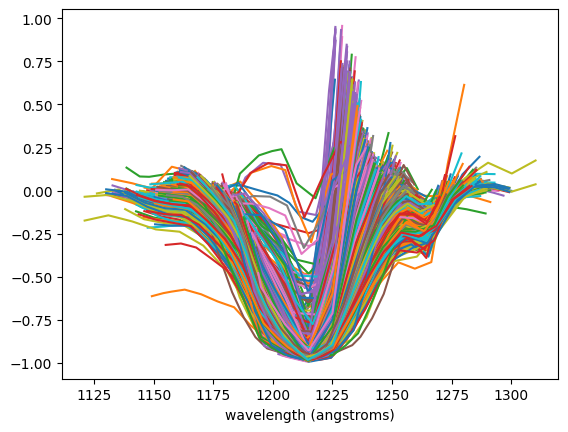

In [4]:
i=0
equiv_widths = []
lyalphas = []
redshifts = []
specs = []
em1s = []
em2s = []
continuums = []

sample = 3000

while(i < sample):
    
    sps.update_model(sps_model, sps_parameters[i], z_history=False, agebins=sfh.default_agebins())
    spectrum_data = sps.fsps_get_sed(sps_model)
    wave = spectrum_data[0]
    sed = sps.redshift_fsps_spectrum(sps_model, spectrum_data)
    redshift = sps_model.params['zred']
    redshifts.append(redshift)



    dlambda = 100
    lyalpha = 1215.16*(1+redshift)
    lyalphas.append(lyalpha)

    l1 = lyalpha - dlambda
    l2 = lyalpha + dlambda

    indx1 = np.where(wave>l1)[0]
    indx2 = np.where(wave<l2)[0]
    indx = np.intersect1d(indx1, indx2)

    em1 = np.interp(l1, wave[indx], sed[indx])
    em2 = np.interp(l2, wave[indx], sed[indx])

    continuum_level = (em2-em1)/(l2-l1)*(lyalpha-l1) + em1
    continuums.append(continuum_level)


    area = np.trapz(sed[indx] - continuum_level, wave[indx])
    equiv_width = area/continuum_level
    equiv_widths.append(equiv_width)
    specs.append((wave, sed))
    plt.plot(wave[indx]/(1+redshift), ((sed[indx]-continuum_level)/area)*equiv_width)

    em1s.append(em1)
    em2s.append(em2)

    i+=1

equiv_widths = np.array(equiv_widths)
em1s = np.array(em1s)
em2s = np.array(em2s)
continuums = np.array(continuums)
lyalphas = np.array(lyalphas)
#plt.yscale('log')
plt.xlabel("wavelength (angstroms)")

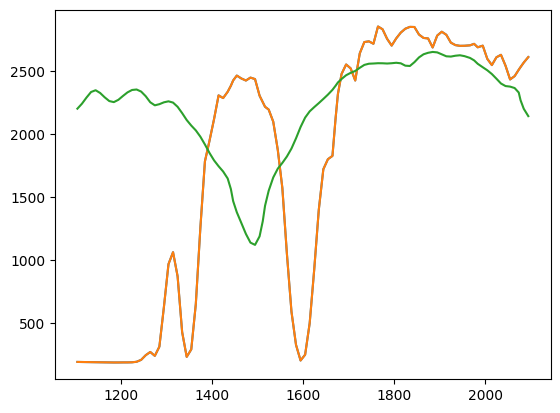

In [16]:
def find_wave_range(wave, l0, dlambda):
    """returns indexes of spectra at wavelengths of interest
    """

    indx1 = np.where(wave>l0-dlambda)[0]
    indx2 = np.where(wave<l0+dlambda)[0]
    indx = np.intersect1d(indx1, indx2)

    return indx

def estimate_continuum(wave, sed, l0, dlambda):
    """lineraly interpolates around l0 to find continuum
    """

    l1 = l0-dlambda
    l2 = l0+dlambda

    em1 = np.interp(l1, wave, sed)
    em2 = np.interp(l2, wave, sed)

    return (em2-em1)/(l2-l1)*(l0-l1) + em1

def lin_interp(wave, sed, l0, dlambda):
    """returns grid of points in a straight line around l0
    """

    l1 = l0-dlambda
    l2 = l0+dlambda

    em1 = np.interp(l1, wave, sed)
    em2 = np.interp(l2, wave, sed)

    return (em2-em1)/(l2-l1)*(wave-l1) + em1

def remove_zeroes(grid, spectrum):

    small_number = 1e-20

    i = 0
    while(spectrum[i] < small_number):
        i+=1
    j = len(spectrum)-1
    while(spectrum[j] < small_number):
        j-=1
    
    return grid[i:j], spectrum[i:j]


    
""""
#def modify_peak(wave, sed, redshift, dlambda, bias):

    lyalpha = 1215.16*(1+redshift)

    indx = find_wave_range(wave, lyalpha, dlambda)
    continuum_level = estimate_continuum(wave, sed, lyalpha, dlambda)

    reduced_spec = sed - continuum_level
    area = abs(np.trapz(reduced_spec[indx], wave[indx]))
    sign = np.sign(np.interp(lyalpha, wave, sed)-continuum_level)
    #area = abs(area)

    sig = 10
    gauss = (1/(np.sqrt(2*np.pi*sig**2)))*np.exp(-0.5*(wave[indx]- (lyalpha+bias))**2/(sig**2))
    modified_spec = gauss*abs(reduced_spec[indx])*sign
    modified_spec = modified_spec/abs(np.trapz(modified_spec, wave[indx]))

    #plt.plot(wave, sed)
    new_sed = np.copy(sed)
    new_sed[indx] = np.ones_like(sed[indx])*lin_interp(wave[indx], sed[indx], lyalpha, dlambda)+modified_spec*area

    indx = find_wave_range(wave, lyalpha, 1000)
    plt.plot(wave[indx], new_sed[indx])
    plt.plot(wave[indx], sed[indx])
    plt.plot(lyalpha,np.interp(lyalpha, wave, sed),'ro') 
    #plt.plot(l1,em1,'ks') 
    plt.plot(lyalpha,continuum_level,'gp')
    #plt.plot(l2,em2,'ks') 
"""
def convolve_peak(wave, sed, redshift, dlambda, wavrange, sig, bias):

    #########
    #MAYBE CENTER LYA AT ZERO BEFORE CONVOLVING? THEN FILTER DEFINED CENTERED AT ZERO
    #########
    
    lyalpha = 1215.16*(1+redshift)
    grid = wave#np.linspace(91, 100000000, 10000000000)
    gaussian = (1/(np.sqrt(2*np.pi*sig**2)))*np.exp(-0.5*(grid-1215.16)**2/(sig**2))
    new_spec = np.interp(grid, wave, sed)

    const = np.zeros_like(grid)
    const[1215] = 9999999999999
    const[1216] = 9999999999999
    const = const/np.trapz(const, grid)

    sed_delta = np.convolve(sed, const, 'same')

    indx = find_wave_range(wave, lyalpha, 500)
    plt.plot(wave[indx], sed[indx])
    indx = find_wave_range(grid, lyalpha, 500)
    plt.plot(grid[indx], new_spec[indx])
    plt.plot(grid[indx], sed_delta[indx])

    #plt.plot(wave, sed)
    #const = const/np.trapz(const, grid)

    #gridspec, spec = remove_zeroes(grid, np.convolve(sed, const, 'full'))
    #gridconv, convolved_spec = remove_zeroes(grid, np.convolve(sed, gaussian, 'full'))

    #plt.plot(gridspec, spec)
    #plt.plot(gridconv, convolved_spec)



    """
    indx = find_wave_range(wave, lyalpha, wavrange)
    indx_peak = find_wave_range(wave, lyalpha, dlambda)

    continuum_level = estimate_continuum(wave[indx_peak], sed[indx_peak], lyalpha, dlambda)
    reduced_sed = sed[indx_peak]-lin_interp(wave[indx_peak], sed[indx_peak], lyalpha, dlambda)
    area = np.trapz(reduced_sed, wave[indx_peak])
    #sign = np.sign(np.interp(lyalpha, wave, sed)-continuum_level)
    equiv_width = area/continuum_level


    new_sed = np.copy(sed)
    gauss = (1/(np.sqrt(2*np.pi*sig**2)))*np.exp(-0.5*(wave-(lyalpha+bias))**2/(sig**2))

    reduced_sed = sed[indx]-lin_interp(wave[indx], sed[indx], lyalpha, wavrange)
    convolved_peak = np.convolve(gauss, reduced_sed, mode='same')

    indx=indx+2
    convolved_peak = np.interp(wave[indx], wave, convolved_peak)
    #plt.plot(convolved_peak)
    #plt.plot(reduced_sed)
    convolve_peak_norm = convolved_peak/np.trapz(convolved_peak, wave[indx])

    new_sed[indx] = convolve_peak_norm*area+lin_interp(wave[indx], sed[indx], lyalpha, wavrange) #- continuum_level


    indx = find_wave_range(wave, lyalpha, 1000)
    plt.plot(wave[indx], new_sed[indx])
    plt.plot(wave[indx], sed[indx])
    #plt.plot(lyalpha,np.interp(lyalpha, wave[indx], sed[indx]),'ro')
    print("equiv:", equiv_width)
    """



j = 0#np.random.randint(0, sample)#424 292#np.random.randint(0, sample)
wave, sed = specs[j]
redshift = redshifts[j]
#modify_peak(wave, sed, redshift, 100, 0)
convolve_peak(wave, sed, redshift, 100, 125, 1, 0)

#print("og ew: ", equiv_widths[j])
#print("no:", j)


Text(0.5, 0, 'wavelength (angstroms)')

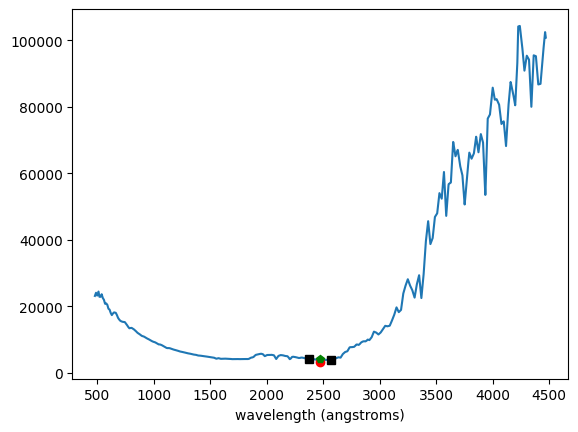

In [6]:
j = np.random.randint(0, sample)
wave, sed = specs[j]
lyalpha = lyalphas[j]
redshift = redshifts[j]

plot_lambda = 2000

l1 = lyalpha - dlambda
l2 = lyalpha + dlambda

indx1 = np.where(wave>lyalpha-plot_lambda)[0]
indx2 = np.where(wave<lyalpha+plot_lambda)[0]
indx = np.intersect1d(indx1, indx2)

em1 = np.interp(l1, wave[indx], sed[indx])
em2 = np.interp(l2, wave[indx], sed[indx])
continuum_level = (em2-em1)/(l2-l1)*(lyalpha-l1) + em1

plt.plot(wave[indx], sed[indx])
plt.plot(lyalpha,np.interp(lyalpha, wave, sed),'ro') 
plt.plot(l1,em1,'ks') 
plt.plot(lyalpha,continuum_level,'gp')
plt.plot(l2,em2,'ks') 

#plt.yscale('log')
plt.xlabel("wavelength (angstroms)")

Text(0.5, 0, 'EW (angstroms)')

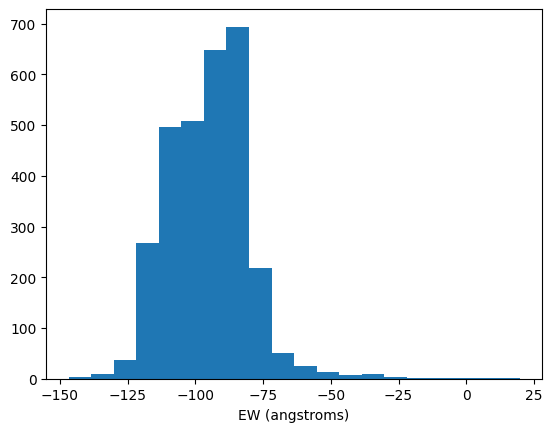

In [7]:
plt.hist(equiv_widths, bins=20)
plt.xlabel("EW (angstroms)")

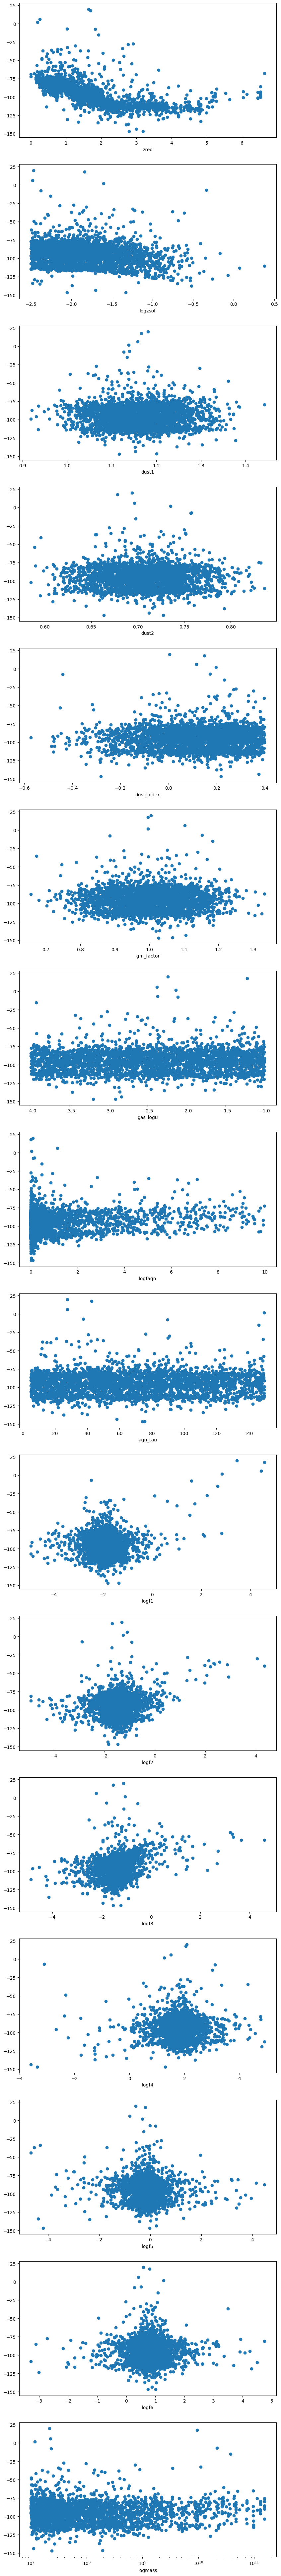

In [8]:
sps_parameter_names = pop.sps_parameter_names()
fig1, axes = plt.subplots(len(sps_parameter_names), 1, figsize=(10,100), sharex=False, sharey=False)

for i in range(0, len(sps_parameter_names)):
    axes[i].scatter(sps_parameters[:sample][:, i], equiv_widths)
    axes[i].set_xlabel(sps_parameter_names[i])
    if(sps_parameter_names[i] == 'logmass'):
        axes[i].set_xscale('log')

563348.7673627344 3397868.7226899555


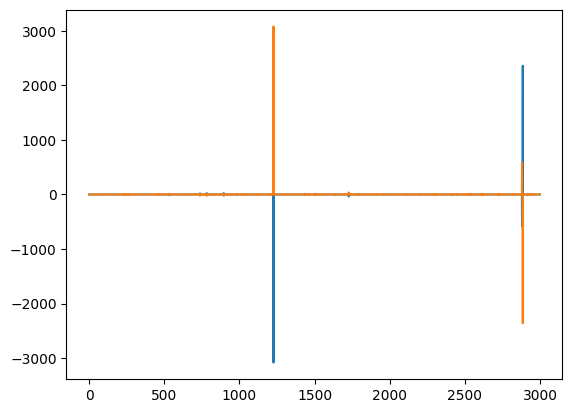

In [9]:
plt.plot((em1s - continuums)/(lyalphas - continuums))
print(np.mean(em1s), np.std(em1s))
plt.plot((em2s - continuums)/(lyalphas - continuums))